## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam
import seaborn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix



Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104040,00027760_000.png,Consolidation,0,27760,38,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027760_000.png
105661,00028433_001.png,Mass|Nodule,1,28433,54,M,PA,3056,2544,0.139,0.139,NaN,/data/images_012/images/00028433_001.png
84969,00020945_020.png,Pneumonia,20,20945,34,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020945_020.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo, performing one-hot-encoding on the "Finding Labels"
data = all_xray_df.copy()
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(all_labels, type(all_labels), "\n")

all_labels = [x for x in all_labels if len(x)>0]
print('Labels ({}): {}, type: {}'.format(len(all_labels), all_labels, type(all_labels)))
for c_label in all_labels:
    if len(c_label)>0: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
data.head(10)

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax'] <class 'numpy.ndarray'> 

Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'], type: <class 'list'>


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0,0,1,0,0,0,0,0,0,0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0,0,1,1,0,0,0,0,0,0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0,0,1,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
# Todo
data['pneumonia_class'] = data.Pneumonia.astype(str)
data.head(1)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Removing all records with age above 95, as the data is misguiding (goes from 148 to 414 years which is definately wrong)
index_names = data[ data['Patient Age'] > 95 ].index 
data.drop(index_names, inplace = True) 

In [6]:
print("Total Records left:", len(data))

Total Records left: 112104


## Create your training and testing data:

In [7]:
print("Total cases", len(data))
print("Total pneumonia cases", data.Pneumonia.sum())
print("Total percentage of pneumonia cases in the dataset", data.Pneumonia.sum()/len(data) *100, "%")


Total cases 112104
Total pneumonia cases 1430
Total percentage of pneumonia cases in the dataset 1.2756012274316706 %


In [8]:
def create_splits(data, test_size=0.2):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = skl.train_test_split(data, 
                                   test_size = 0.2, 
                                   stratify = data["pneumonia_class"])
    
    # now, since we keed the ration of "Pneumonia" to other classes same in validation set we will not change the validation data
    # but, we have to balance the "Pneumonia" and no pneumonia to be equal in training data set:
    positive = train_df[train_df.Pneumonia==1].index.tolist()
    negative = train_df[train_df.Pneumonia==0].index.tolist()
    negative_sample = sample(negative,len(positive))
    train_df = train_df.loc[positive + negative_sample]
    
    
    # balancing validation set to 20-80%, 20% positive and 80% negative
    positive_pn = valid_df[valid_df.Pneumonia==1].index.tolist()
    negative_pn = valid_df[valid_df.Pneumonia==0].index.tolist()
    
    negative_sample_pn = sample(negative_pn,4*len(positive_pn))
    valid_df = valid_df.loc[positive_pn + negative_sample_pn]
    
    
    
    print("pneumonia records in  train", len(train_df[train_df.pneumonia_class=="1"]))
    print("Ratio of pneumonia in train", len(train_df[train_df.pneumonia_class=="1"])/len(train_df))
    print("Total test cases", len(valid_df))
    print("pneumonia records in  test", len(valid_df[valid_df.pneumonia_class=="1"]))
    print("Ratio of pneumonia in test", len(valid_df[valid_df.pneumonia_class=="1"])/len(valid_df))
    

    return train_df, valid_df

In [9]:
# Check the output
train_df, valid_df = create_splits(data)
len(valid_df)

pneumonia records in  train 1144
Ratio of pneumonia in train 0.5
Total test cases 1430
pneumonia records in  test 286
Ratio of pneumonia in test 0.2


1430

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 90]
Age Distribition in training data


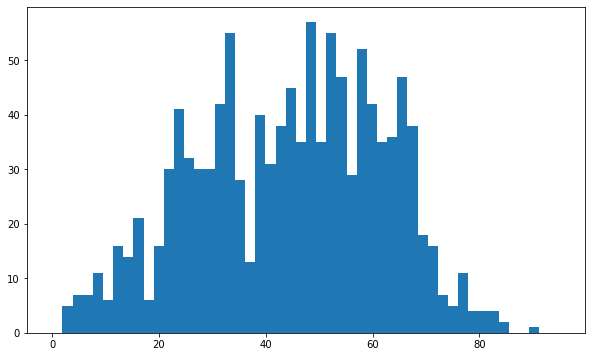

In [14]:
# Age distribution
plt.figure(figsize=(10,6))
plt.hist(train_df[train_df.Pneumonia == 1]['Patient Age'], range=(0, 95), bins=50)
all_ages = train_df["Patient Age"].unique()
print(np.sort(all_ages))
print("Age Distribition in training data")

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 85 87 93]
Age Distribition in Validation data


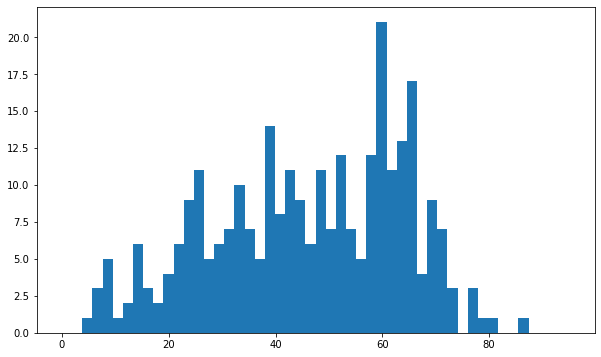

In [15]:
# Age distribution
plt.figure(figsize=(10,6))
plt.hist(valid_df[valid_df.Pneumonia == 1]['Patient Age'], range=(0, 95), bins=50)
all_ages = valid_df["Patient Age"].unique()
print(np.sort(all_ages))
print("Age Distribition in Validation data")

Gender Distribution in training data
M    1346
F     942
Name: Patient Gender, dtype: int64
Male Patient: 0.5882867132867133
Female Patient: 0.4117132867132867
difference: 0.17657342657342662


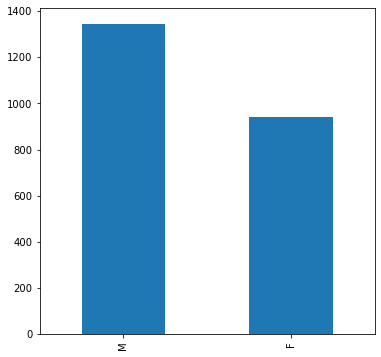

In [17]:
plt.figure(figsize=(6,6))
# data['Patient Gender'].value_counts().plot(kind='bar')
# train_df, valid_df
gender_records_all = train_df['Patient Gender'].value_counts()
gender_records_all.plot(kind='bar')
total_records = len(train_df)
print("Gender Distribution in training data")
print(gender_records_all)
print("Male Patient:", gender_records_all[0]/total_records)
print("Female Patient:", gender_records_all[1]/total_records)
print("difference:", gender_records_all[0]/total_records - gender_records_all[1]/total_records)

Gender Distribution in validation data
M    797
F    633
Name: Patient Gender, dtype: int64
Male Patient: 0.5573426573426573
Female Patient: 0.44265734265734263
difference: 0.11468531468531468


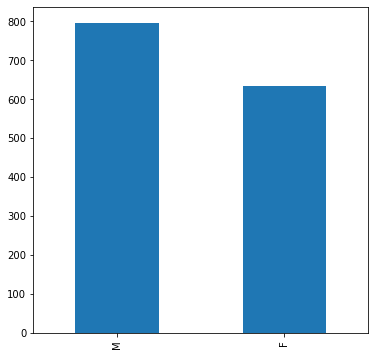

In [18]:
plt.figure(figsize=(6,6))
# data['Patient Gender'].value_counts().plot(kind='bar')
# train_df, valid_df
gender_records_all = valid_df['Patient Gender'].value_counts()
gender_records_all.plot(kind='bar')
total_records = len(valid_df)
print("Gender Distribution in validation data")
print(gender_records_all)
print("Male Patient:", gender_records_all[0]/total_records)
print("Female Patient:", gender_records_all[1]/total_records)
print("difference:", gender_records_all[0]/total_records - gender_records_all[1]/total_records)

0.08%, 329, Atelectasis
0.014%, 59, Cardiomegaly
0.038%, 155, Consolidation
0.073%, 302, Edema
0.087%, 359, Effusion
0.012%, 50, Emphysema
0.006%, 26, Fibrosis
0.0%, 2, Hernia
0.168%, 693, Infiltration
0.028%, 116, Mass
0.146%, 602, No Finding
0.03%, 124, Nodule
0.02%, 81, Pleural_Thickening
0.277%, 1144, Pneumonia
0.021%, 86, Pneumothorax
Total Records  2288


[Text(0, 0.5, 'Number of Images with Label')]

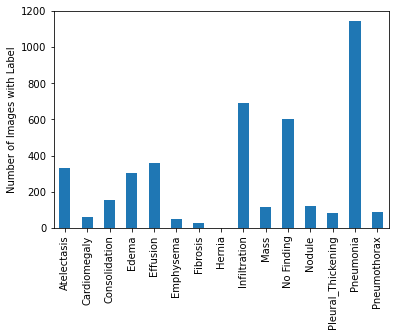

In [19]:
# train_df, valid_df
data_for_ax = train_df[all_labels].sum()

index = data_for_ax.index
a_list = list(index)
total = data_for_ax.sum()
for index, value in enumerate(data_for_ax):
    print(("{}%, {}, {}").format(round(value/total,3), data_for_ax[index], all_labels[index]))

print("Total Records ",len(train_df))

ax = data_for_ax.plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

0.088%, 186, Atelectasis
0.01%, 21, Cardiomegaly
0.031%, 66, Consolidation
0.043%, 92, Edema
0.093%, 197, Effusion
0.016%, 33, Emphysema
0.008%, 18, Fibrosis
0.001%, 2, Hernia
0.161%, 341, Infiltration
0.034%, 73, Mass
0.286%, 606, No Finding
0.042%, 89, Nodule
0.021%, 44, Pleural_Thickening
0.135%, 286, Pneumonia
0.031%, 66, Pneumothorax
Total Records  1430


[Text(0, 0.5, 'Number of Images with Label')]

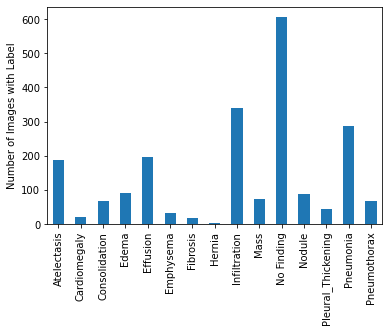

In [20]:
# train_df, valid_df
data_for_ax = valid_df[all_labels].sum()

index = data_for_ax.index
a_list = list(index)
total = data_for_ax.sum()
for index, value in enumerate(data_for_ax):
    print(("{}%, {}, {}").format(round(value/total,3), data_for_ax[index], all_labels[index]))

print("Total Records ",len(valid_df))

ax = data_for_ax.plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Position Records for all Training the data
PA    1189
AP    1099
Name: View Position, dtype: int64
PA : 0.5196678321678322
AP : 0.4803321678321678
difference: 0.03933566433566438


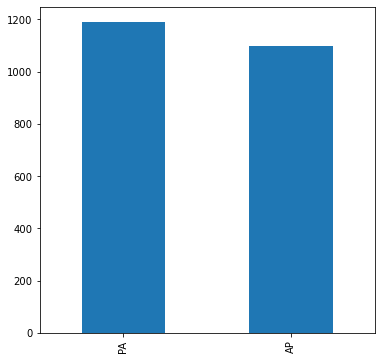

In [21]:
# train_df, valid_df
plt.figure(figsize=(6,6))
position_records = train_df['View Position'].value_counts()
position_records.plot(kind='bar')
print("Position Records for all Training the data")
print(position_records)
total_records = len(train_df['View Position'])
print("PA :", position_records[0]/total_records)
print("AP :", position_records[1]/total_records)
print("difference:", position_records[0]/total_records - position_records[1]/total_records)


Position Records for all Validation the data
PA    816
AP    614
Name: View Position, dtype: int64
PA : 0.5706293706293706
AP : 0.42937062937062936
difference: 0.14125874125874122


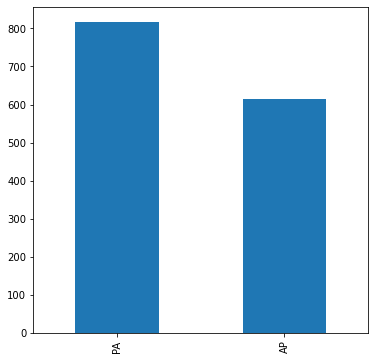

In [22]:
# train_df, valid_df
plt.figure(figsize=(6,6))
position_records = valid_df['View Position'].value_counts()
position_records.plot(kind='bar')
print("Position Records for all Validation the data")
print(position_records)
total_records = len(valid_df['View Position'])
print("PA :", position_records[0]/total_records)
print("AP :", position_records[1]/total_records)
print("difference:", position_records[0]/total_records - position_records[1]/total_records)


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
def my_image_augmentation(is_train):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    if is_train == True:
        my_idg = ImageDataGenerator(rescale=1. / 255.0,
                                    horizontal_flip = True, 
                                    vertical_flip = False, 
                                    height_shift_range= 0.1, 
                                    width_shift_range=0.1, 
                                    rotation_range=10, 
                                    shear_range = 0.1,
                                    zoom_range=0.1)
        print("Getting for Training")
    else:
        my_idg = ImageDataGenerator(rescale=1. / 255.0)
        print("Getting for Validation/Testing")
            
    
    
    return my_idg


def make_train_gen(data_frame, path, label, image_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = my_image_augmentation(is_train = True).flow_from_dataframe(dataframe=data_frame, 
                                                                           directory=None,
                                                                           x_col = path,
                                                                           y_col = label,
                                                                           class_mode = 'binary',
                                                                           target_size = image_size,
                                                                           batch_size = batch_size )

    return train_gen


def make_val_gen(data_frame, path, label, image_size, batch_size):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_gen =  my_image_augmentation(is_train = False).flow_from_dataframe(dataframe=data_frame,
                                                     directory=None,
                                                     x_col = path,
                                                     y_col = label,
                                                     class_mode = 'binary',
                                                     target_size = image_size,
                                                     batch_size = batch_size )
    return val_gen

In [16]:
# Lets first check which Devices are available
# device_lib.list_local_devices()    

In [17]:
# Based on abouve, we have a GPU Tesla K80: https://www.nvidia.com/en-gb/data-center/tesla-k80/, so we can make a big batch size, as lot of GPU processing and GPU ram is available
TOTAL_TRAIN_IMAGES = len(train_df)
TOTAL_VALID_IMAGES = len(valid_df)
print(TOTAL_TRAIN_IMAGES, TOTAL_VALID_IMAGES)

BATCH_SIZE = 64



# We are goinng to use VGG16, so the input image size:
IMAGE_SIZE = (224, 224)

2288 1430


In [18]:
train_gen = make_train_gen(train_df, "path", "pneumonia_class", IMAGE_SIZE, BATCH_SIZE)
val_gen = make_val_gen(valid_df, "path", "pneumonia_class", IMAGE_SIZE, BATCH_SIZE)

Getting for Training
Found 2288 validated image filenames belonging to 2 classes.
Getting for Validation/Testing
Found 1430 validated image filenames belonging to 2 classes.


In [19]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

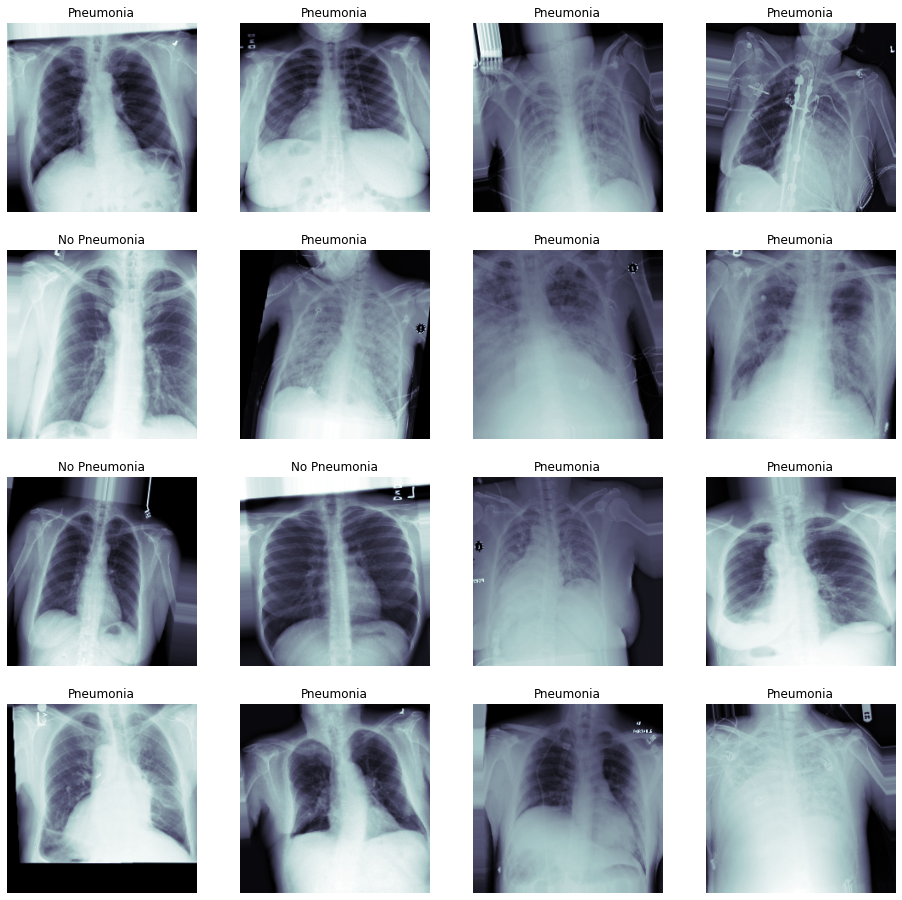

In [15]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [20]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
#     model = VGG16(include_top=True, weights='imagenet')
    model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    
    
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:16]:
        layer.trainable = False
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    return vgg_model


In [21]:
load_pretrained_model()

58892288/58889256 [==============================] - 1s 0us/step
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_pool True


In [65]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    pretrained_model = load_pretrained_model()
    pretrained_model.summary()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.45))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.4))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [66]:
tf.keras.backend.clear_session()
my_model = build_my_model()
my_model.summary()

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_pool True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________

In [20]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "min", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "min", 
                      patience=15)

callbacks_list = [checkpoint, early]

### Start training! 

In [21]:
optimizer = Adam(learning_rate=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [22]:
## train your model

# Todo
# history = my_model.fit_generator(train_gen, 
#                                  validation_data = val_gen, 
#                                  validation_steps = len(valid_df)// BATCH_SIZE,
#                                  epochs = 10,
#                                  callbacks = callbacks_list)
history = my_model.fit_generator(train_gen, 
                                 validation_data = val_gen, 
                                 epochs = 50,
                                 callbacks = callbacks_list)

Epoch 1/50
36/36 [==============================] - 88s 2s/step - loss: 0.7683 - binary_accuracy: 0.5118 - val_loss: 0.6593 - val_binary_accuracy: 0.5790

Epoch 00001: val_loss improved from inf to 0.65931, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
36/36 [==============================] - 61s 2s/step - loss: 0.7656 - binary_accuracy: 0.5031 - val_loss: 0.6643 - val_binary_accuracy: 0.6538

Epoch 00002: val_loss did not improve from 0.65931
Epoch 3/50
36/36 [==============================] - 65s 2s/step - loss: 0.7721 - binary_accuracy: 0.5009 - val_loss: 0.6376 - val_binary_accuracy: 0.6657

Epoch 00003: val_loss improved from 0.65931 to 0.63757, saving model to xray_class_my_model.best.hdf5
Epoch 4/50
36/36 [==============================] - 64s 2s/step - loss: 0.7609 - binary_accuracy: 0.5192 - val_loss: 0.6195 - val_binary_accuracy: 0.6839

Epoch 00004: val_loss improved from 0.63757 to 0.61954, saving model to xray_class_my_model.best.hdf5
Epoch 5/50
36/36 [=========

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [31]:
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

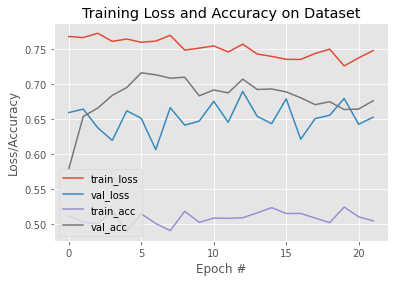

In [32]:
## plot figures
plot_history(history)


In [33]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = BATCH_SIZE, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [34]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (6, 6))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (6, 6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def plot_precision_recall_to_threashold_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1, 1, figsize=(6,6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    print(len(thresholds), len(precision[:-1]), len(recall[:-1]))
    c_ax.plot(thresholds, precision[:-1], color='blue', label="precision")
    c_ax.plot(thresholds, recall[:-1], color='red', label="recall")
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('precision and recall')
        

# function to calculate the F1 score
def calc_F1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_f1_thresh(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (6, 6))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1_score = calc_F1(precision, recall)
    f1_score = f1_score[:-1]
    c_ax.plot(thresholds, f1_score, label = '%s (F1 Score:)'% ('Pneumonia'))
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1 Score')




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


50 50 50


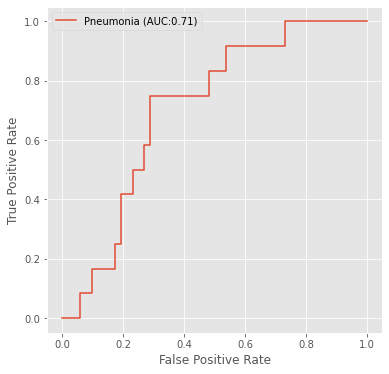

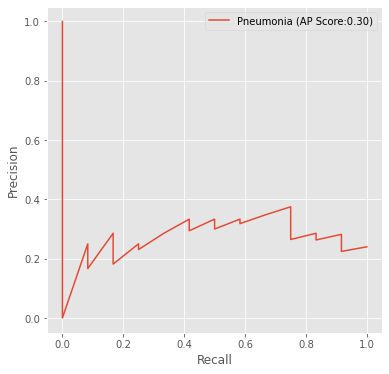

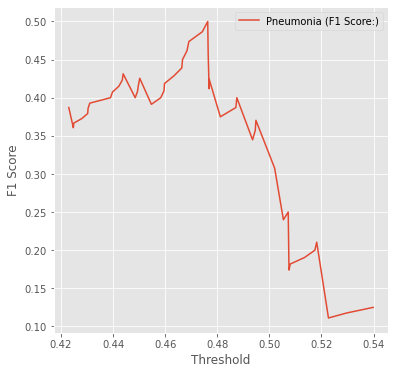

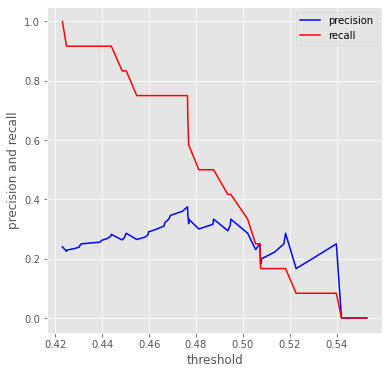

In [35]:
# Todo valX, valY
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)
plot_f1_thresh(valY, pred_Y)
plot_precision_recall_to_threashold_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [36]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
thresholds = []
for thresh in np.arange(0.1, 0.5, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(valY, (pred_Y > thresh).astype(int))
    thresholds.append([thresh, score])
    print("F1 score: {0}, threshold: {1}".format(score, thresh))

thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Optimal threshold: ", best_thresh)

F1 score: 0.3157894736842105, threshold: 0.1
F1 score: 0.3157894736842105, threshold: 0.11
F1 score: 0.3157894736842105, threshold: 0.12
F1 score: 0.3157894736842105, threshold: 0.13
F1 score: 0.3157894736842105, threshold: 0.14
F1 score: 0.3157894736842105, threshold: 0.15
F1 score: 0.3157894736842105, threshold: 0.16
F1 score: 0.3157894736842105, threshold: 0.17
F1 score: 0.3157894736842105, threshold: 0.18
F1 score: 0.3157894736842105, threshold: 0.19
F1 score: 0.3157894736842105, threshold: 0.2
F1 score: 0.3157894736842105, threshold: 0.21
F1 score: 0.3157894736842105, threshold: 0.22
F1 score: 0.3157894736842105, threshold: 0.23
F1 score: 0.3157894736842105, threshold: 0.24
F1 score: 0.3157894736842105, threshold: 0.25
F1 score: 0.3157894736842105, threshold: 0.26
F1 score: 0.3157894736842105, threshold: 0.27
F1 score: 0.3157894736842105, threshold: 0.28
F1 score: 0.3157894736842105, threshold: 0.29
F1 score: 0.3157894736842105, threshold: 0.3
F1 score: 0.3157894736842105, thresho

In [45]:
def plot_confution_mat(valY, pred_Y, thresholds):
    for t in thresholds:
        tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > t).astype(int)).ravel()
        ppv = np.round(tp/(tp+fp), 2)
        npv = np.round(tn/(tn+fn), 2)
        recall = np.round(tp/(tp+fn), 2)
        precision = np.round(tp/(tp+fp), 2)
        fpr = np.round(tn/(tn+fp), 2)
        print(f'Threshold:{t} :- TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}, ppv: {ppv}, npv: {npv}, recall: {recall}, precision: {precision}, fpr: {fpr},')

In [46]:
model_thresholds = [0.35, 0.37, 0.39, 0.47, 0.48, 0.49, 0.5]
plot_confution_mat(valY, pred_Y, model_thresholds)

Threshold:0.35 :- TP: 12, FP: 51, FN: 0, TN: 1, ppv: 0.19, npv: 1.0, recall: 1.0, precision: 0.19, fpr: 0.02,
Threshold:0.37 :- TP: 12, FP: 49, FN: 0, TN: 3, ppv: 0.2, npv: 1.0, recall: 1.0, precision: 0.2, fpr: 0.06,
Threshold:0.39 :- TP: 12, FP: 45, FN: 0, TN: 7, ppv: 0.21, npv: 1.0, recall: 1.0, precision: 0.21, fpr: 0.13,
Threshold:0.47 :- TP: 9, FP: 16, FN: 3, TN: 36, ppv: 0.36, npv: 0.92, recall: 0.75, precision: 0.36, fpr: 0.69,
Threshold:0.48 :- TP: 6, FP: 14, FN: 6, TN: 38, ppv: 0.3, npv: 0.86, recall: 0.5, precision: 0.3, fpr: 0.73,
Threshold:0.49 :- TP: 5, FP: 12, FN: 7, TN: 40, ppv: 0.29, npv: 0.85, recall: 0.42, precision: 0.29, fpr: 0.77,
Threshold:0.5 :- TP: 4, FP: 10, FN: 8, TN: 42, ppv: 0.29, npv: 0.84, recall: 0.33, precision: 0.29, fpr: 0.81,


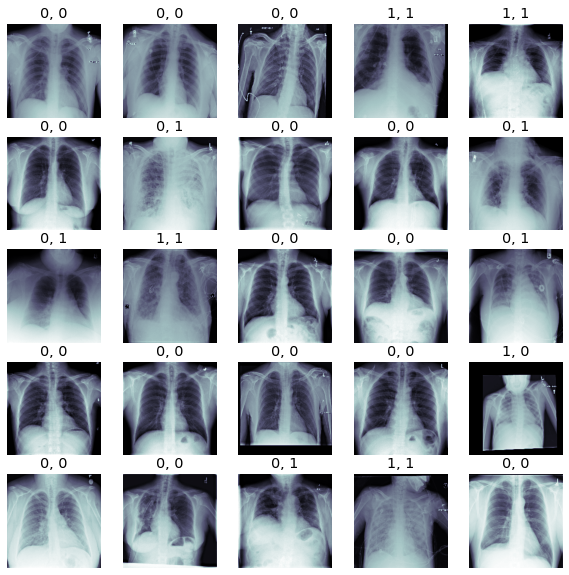

In [47]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(5, 5, figsize = (10, 10))
i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > 0.36:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > 0.36: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.47:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.47: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [48]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)